# Step 1.3: Multi-temporal NDVI Processing for Dust Source Identification

## Objective
To construct a temporally consistent NDVI dataset that represents surface
vegetation conditions over time.

Since dust emission primarily originates from bare or sparsely vegetated land,
NDVI is used as a proxy to identify potential dust source regions.

This notebook prepares NDVI data only.
No atmospheric or machine learning processing is performed here.


In [1]:
import numpy as np
import rasterio
import glob
import os
from tqdm import tqdm


In [2]:
# Path to daily NDVI GeoTIFF files
ndvi_dir = "../data/ndvi_daily"

# Output directory
os.makedirs("../outputs", exist_ok=True)

# Collect NDVI files (sorted by time)
ndvi_files = sorted(glob.glob(os.path.join(ndvi_dir, "*.tif")))

if len(ndvi_files) == 0:
    raise FileNotFoundError("No NDVI GeoTIFF files found")

print(f"Number of NDVI files found: {len(ndvi_files)}")
print("First file:", os.path.basename(ndvi_files[0]))


Number of NDVI files found: 14
First file: ndvi_day_01.tif


In [3]:
# Use first NDVI file as spatial reference
with rasterio.open(ndvi_files[0]) as src:
    ref_profile = src.profile
    ref_transform = src.transform
    ref_shape = src.read(1).shape

print("Reference NDVI shape:", ref_shape)


Reference NDVI shape: (10342, 12242)


In [4]:
#This creates the temporal NDVI cube.
ndvi_stack = []

for f in tqdm(ndvi_files, desc="Loading NDVI files"):
    with rasterio.open(f) as src:
        ndvi = src.read(1).astype(np.float32)
        ndvi_stack.append(ndvi)

ndvi_stack = np.stack(ndvi_stack, axis=0)

print("NDVI stack shape (time, lat, lon):", ndvi_stack.shape)


Loading NDVI files: 100%|██████████| 14/14 [00:31<00:00,  2.26s/it]


NDVI stack shape (time, lat, lon): (14, 10342, 12242)


In [8]:
# STEP 1.3 — Memory-Safe Multi-temporal NDVI Processing

import numpy as np
import rasterio
import glob
import os
from tqdm import tqdm

ndvi_dir = "../data/ndvi_daily"
ndvi_files = sorted(glob.glob(os.path.join(ndvi_dir, "*.tif")))

if len(ndvi_files) == 0:
    raise FileNotFoundError("No NDVI files found")

# Downsampling factor (VERY IMPORTANT)
downsample_factor = 8   # <- increase if memory is still tight

ndvi_processed = []

for f in tqdm(ndvi_files, desc="Processing NDVI safely"):
    with rasterio.open(f) as src:
        ndvi = src.read(1)  # read one frame only

        # Downsample IMMEDIATELY (before anything else)
        ndvi = ndvi[::downsample_factor, ::downsample_factor]

        # Convert to float32 AFTER downsampling
        ndvi = ndvi.astype(np.float32)

        # Handle NaNs frame-wise
        ndvi[np.isnan(ndvi)] = 0.0

        # Normalize NDVI from [-1,1] → [0,1]
        ndvi = (ndvi + 1.0) / 2.0
        ndvi = np.clip(ndvi, 0.0, 1.0)

        ndvi_processed.append(ndvi)

# Stack after all frames are SAFE
ndvi_stack = np.stack(ndvi_processed, axis=0)

print("Final NDVI stack shape:", ndvi_stack.shape)

# Save output
os.makedirs("../outputs", exist_ok=True)
np.save("../outputs/ndvi_stack.npy", ndvi_stack)

print("✅ NDVI stack saved safely")


Processing NDVI safely: 100%|██████████| 14/14 [00:19<00:00,  1.36s/it]


Final NDVI stack shape: (14, 1293, 1531)
✅ NDVI stack saved safely


In [11]:
# OPTIONAL: Temporal smoothing on final NDVI stack (memory-safe)

import numpy as np

kernel = 3  # 3-time-step moving average

ndvi_smooth = np.empty_like(ndvi_stack)

for t in range(ndvi_stack.shape[0]):
    start = max(0, t - kernel // 2)
    end = min(ndvi_stack.shape[0], t + kernel // 2 + 1)
    ndvi_smooth[t] = np.mean(ndvi_stack[start:end], axis=0)

# Replace original stack with smoothed version
ndvi_stack = ndvi_smooth

print("Temporal smoothing applied ✅")


Temporal smoothing applied ✅


In [12]:
np.save("../outputs/ndvi_stack.npy", ndvi_stack)
print("Final NDVI stack saved")


Final NDVI stack saved


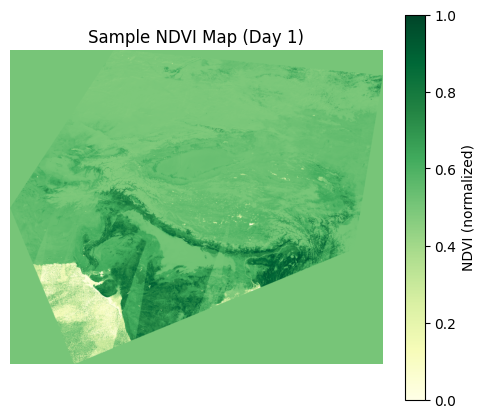

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.imshow(ndvi_smooth[0], cmap="YlGn")
plt.colorbar(label="NDVI (normalized)")
plt.title("Sample NDVI Map (Day 1)")
plt.axis("off")
plt.show()
